## Recognition of hand drawings with CNNs and using the dataset of Quick-Draw API & generating synonyms of the predicted drawing

* Minor Applied Artificial Intelligence HvA
* Aghead Bilal

### Importing packages

In [1]:
%load_ext tensorboard

In [2]:
import datetime, os
import tensorflow as tf

from PIL import Image
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from quickdraw import QuickDrawDataGroup, QuickDrawData

from tensorflow.keras.preprocessing import image_dataset_from_directory

from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization

from tensorflow.keras.callbacks import TensorBoard

### Dataset generation

In [3]:
image_size = (28, 28)

To train the neural network, we generate our own dataset by making slight modifications to the Google dataset. <br>
We will employee a Python package called quickdraw to download and access the dataset from the Google Cloud Platform.

In [11]:
# Load 1200 training images for each class from the cloud storage
# Resize each image to 28x28 pixels
# Save the resized images in PNG format
def generate_class_images(name, max_drawings, recognized):
    directory = Path("dataset/" + name)

    if not directory.exists():
        directory.mkdir(parents=True)

    # If recognized=True is set, it guarantees that only images recognized by Google's AI will be loaded.
    images = QuickDrawDataGroup(name, max_drawings=max_drawings, recognized=recognized)
    for img in images.drawings:
        filename = directory.as_posix() + "/" + str(img.key_id) + ".png"
        img.get_image(stroke_width=3).resize(image_size).save(filename)

for label in QuickDrawData().drawing_names:
    generate_class_images(label, max_drawings=1200, recognized=True)

loading aircraft carrier drawings
load complete
loading airplane drawings
load complete
loading alarm clock drawings
load complete
loading ambulance drawings
load complete
loading angel drawings
load complete


KeyboardInterrupt: 

### Dataset loading/splitting

The images will be loaded using the Keras image_dataset_from_directory function and will then be divided into training and validation sets.

In [4]:
# Batch size is a hyperparameter that determines the number of training examples used in one iteration
batch_size = 32 

# The dataset will be split into an 80% training set and a 20% validation set.
train_ds = image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="training",
    seed=123,
    color_mode="grayscale",
    image_size=image_size,
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="validation",
    seed=123,
    color_mode="grayscale",
    image_size=image_size,
    batch_size=batch_size
)

Found 414000 files belonging to 345 classes.
Using 331200 files for training.
Found 414000 files belonging to 345 classes.
Using 82800 files for validation.


### Visualization

After we split the dataset, let's visualize some random training images.

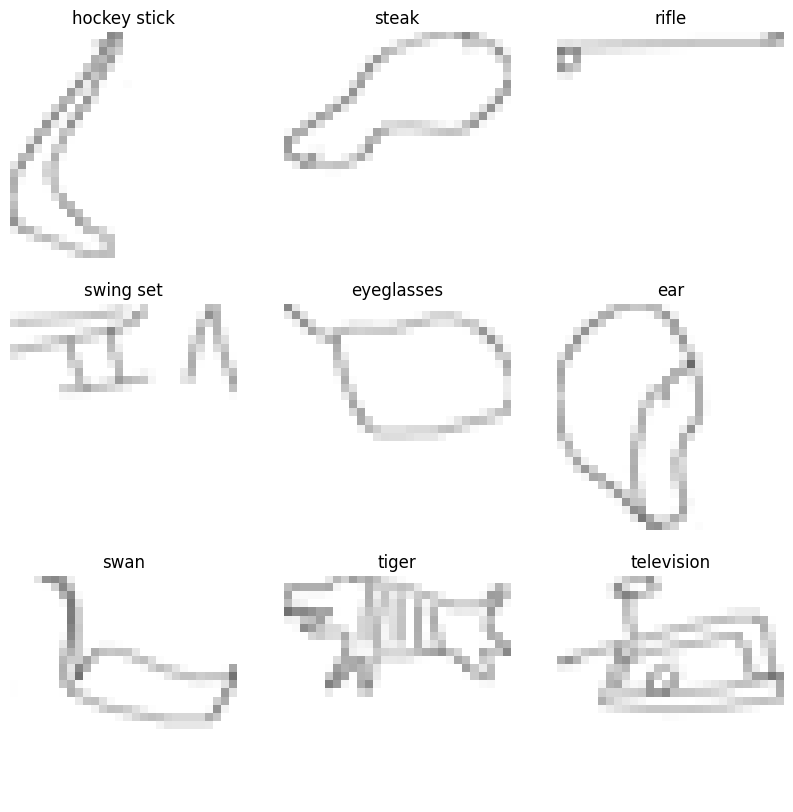

In [18]:
# plot 9 random hand drawings with its title from the training set
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        data = images[i].numpy().astype("uint8")
        plt.imshow(data, cmap='gray', vmin=0, vmax=255)
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

### Architecture (Building CNN)

We will start by using the seven Keras layers to create our convolutional neural network.

In [ ]:
input_shape = (28, 28, 1)
n_classes = 345

model = Sequential([
    Rescaling(1. / 255, input_shape=input_shape),
    BatchNormalization(),

    Conv2D(6, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(8, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(10, kernel_size=(3, 3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(700, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(500, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(400, activation='relu'),
    Dropout(0.2),

    Dense(n_classes, activation='softmax')
])

In [ ]:
model.compile(
    optimizer="adam",
    loss=SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

In [ ]:
model.summary()

### Training

We will train the convolutional neural network for 10 epochs using the Quick, Draw! dataset (for improvement)

In [ ]:
epochs = 10

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[tensorboard_callback]
)

model.save('./models/model_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
# The accuracy of the model on the validation set
val_loss, val_acc = model.evaluate(val_ds)
print("Validation accuracy: ", val_acc)

# The accuracy of the model on the training set
train_loss, train_acc = model.evaluate(train_ds)
print("Training accuracy: ", train_acc)


<b>

The validation accuracy is lower than the training accuracy, which is expected because the model has learned to fit the training data well, but it may not generalize well to new data.

An accuracy of 62% is actually not bad considering that there are 345 categories, some of which may be quite similar to each other.

Overall, the model's performance can be considered moderate, but it may be improved with further optimization.

In [ ]:
# plot 9 drawings from the validation set and its prediction from the model
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        data = images[i].numpy().astype("uint8")
        plt.imshow(data, cmap='gray', vmin=0, vmax=255)
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

        prediction = model.predict(images[i:i+1])
        print("Prediction: ", train_ds.class_names[tf.argmax(prediction[0])])

In [ ]:
%tensorboard --logdir logs

### Improving CNN

In [ ]:
# improve the model by adding more layers
model = Sequential([
    Rescaling(1. / 255, input_shape=input_shape),
    BatchNormalization(),

    Conv2D(6, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(8, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(10, kernel_size=(3, 3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(12, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(14, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(16, kernel_size=(3, 3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Flatten(),

    Dense(700, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(500, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(400, activation='relu'),
    Dropout(0.2),

    Dense(n_classes, activation='softmax')
])

In [ ]:
model.compile(
    optimizer="adam",
    loss=SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

In [ ]:
model.summary()

We will train the improved convolutional neural network for 40 epochs using the Quick, Draw! dataset (for improvement)

In [ ]:
epochs = 40

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[tensorboard_callback]
)

model.save('./models/model_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
# The accuracy of the model on the validation set
val_loss, val_acc = model.evaluate(val_ds)
print("Validation accuracy: ", val_acc)

# The accuracy of the model on the training set
train_loss, train_acc = model.evaluate(train_ds)
print("Training accuracy: ", train_acc)

<b>

After adding more layers we got an accuracy of 65%

In [5]:
# Load 
model = tf.keras.models.load_model('./models/model_20230520-222940')

1/1 [==============================] - 0s 232ms/step
Prediction:  shovel
1/1 [==============================] - 0s 17ms/step
Prediction:  sun
1/1 [==============================] - 0s 16ms/step
Prediction:  bear
1/1 [==============================] - 0s 17ms/step
Prediction:  shark
1/1 [==============================] - 0s 16ms/step
Prediction:  pizza
1/1 [==============================] - 0s 17ms/step
Prediction:  snowman
1/1 [==============================] - 0s 17ms/step
Prediction:  duck
1/1 [==============================] - 0s 16ms/step
Prediction:  rake
1/1 [==============================] - 0s 17ms/step
Prediction:  bottlecap


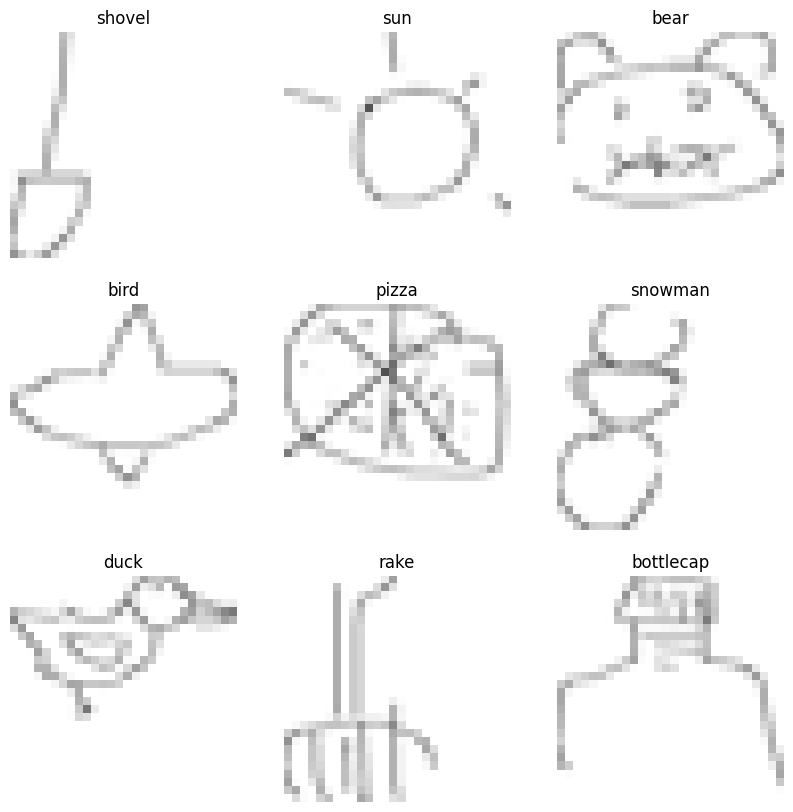

In [6]:
# plot 9 drawings from the validation set and its prediction from the model
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        data = images[i].numpy().astype("uint8")
        plt.imshow(data, cmap='gray', vmin=0, vmax=255)
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

        prediction = model.predict(images[i:i+1])
        print("Prediction: ", train_ds.class_names[tf.argmax(prediction[0])])

1/1 [==============================] - 0s 16ms/step
Prediction:  microwave


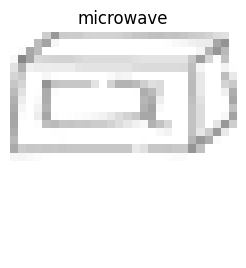

In [8]:
# plot a  drawing from the validation set and its prediction from the model
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
    ax = plt.subplot(3, 3, 1)
    data = images[0].numpy().astype("uint8")
    plt.imshow(data, cmap='gray', vmin=0, vmax=255)
    plt.title(train_ds.class_names[labels[0]])
    plt.axis("off")

    prediction = model.predict(images[0:1])
    print("Prediction: ", train_ds.class_names[tf.argmax(prediction[0])])

### Recognize human hand drawings 

In [9]:
def increase_brightness(image_path, brightness_factor):
    # Open the image using PIL
    image = Image.open(image_path)

    # Convert the image to RGB mode if it's not already
    image = image.convert("RGB")

    # Create a new blank image with the same size and mode as the original image
    brightened_image = Image.new("RGB", image.size)

    # Iterate over each pixel in the image
    for x in range(image.width):
        for y in range(image.height):
            # Get the pixel value at the current position
            r, g, b = image.getpixel((x, y))

            # Increase the brightness by multiplying each color channel by the brightness factor
            r = min(255, int(r * brightness_factor))
            g = min(255, int(g * brightness_factor))
            b = min(255, int(b * brightness_factor))

            # Set the new pixel value in the brightened image
            brightened_image.putpixel((x, y), (r, g, b))

    # Return the brightened image
    return brightened_image

In [10]:
image_path = "new_drawings/cat.png"
brightness_factor = 1.5 # Adjust the brightness factor as desired

brightened_image = increase_brightness(image_path, brightness_factor)

# Save the brightened image
brightened_image.save("new_drawings/brightened_image.png")


In [11]:
# Open the image
image = Image.open("new_drawings/brightened_image.png")

# Resize the image while maintaining aspect ratio
image.thumbnail((28, 28))

# Create a square image by cropping it from the center
width, height = image.size
size = min(width, height)
left = (width - size) // 2
top = (height - size) // 2
right = (width + size) // 2
bottom = (height + size) // 2
cropped_image = image.crop((left, top, right, bottom))

# Convert the image to grayscale
cropped_image = cropped_image.convert("L")

# Resize the image to 28x28 pixels
cropped_image = cropped_image.resize((28, 28))

# Convert the image to a numpy array
image_array = np.array(cropped_image)

# Reshape the image array to add the channel dimension
image_array = image_array.reshape((1, 28, 28, 1))

# Normalize the image array (optional)
image_array = image_array / 255.0

# Save the preprocessed image
preprocessed_image = Image.fromarray(np.squeeze(image_array * 255).astype(np.uint8))
preprocessed_image.save("new_drawings/preprocessed_image.png")


1/1 [==============================] - 0s 17ms/step
Prediction:  cat


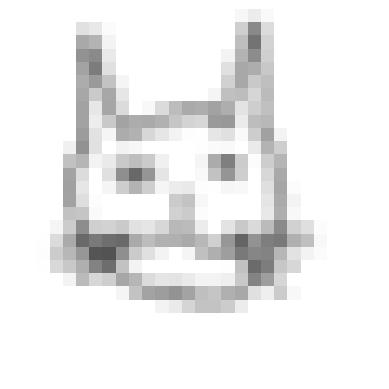

In [12]:
# predict hand drawn image
img = tf.keras.preprocessing.image.load_img(
    "new_drawings/preprocessed_image.png", color_mode="grayscale", target_size=image_size
)

plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.axis("off")

img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

prediction = model.predict(img_array)
print("Prediction: ", train_ds.class_names[tf.argmax(prediction[0])])

### word vectorization of the predicted drawing

In [13]:
from transformers import pipeline

# find synonyms for the predicted word of the hand drawn image
synonym_word = train_ds.class_names[tf.argmax(prediction[0])]
textstr = "Similar words to " + synonym_word + " are: [MASK]."

# print the predicted word
print("Prediction: ", synonym_word)

#create a pipeline for masked language modeling using BERT
bert_model = pipeline('fill-mask', model='bert-base-uncased')

#get synonym predictions for the masked text
synonym_prediction = bert_model(textstr, top_k=50)

#initialize a list to store the filtered words
filtered_words_list = []

#iterate through the synonym predictions
for x in synonym_prediction:
    token_str = x['token_str']

#filter out non-alphabetic tokens
    if token_str.isalpha():
        filtered_words_list.append(token_str)

#print the filtered words with some editing.


filtered_words = [];

# The words to get removed.
withS = synonym_word + 's'
withCapital = synonym_word.capitalize()
withBoth = withS.capitalize()

# Remove words that add an s, or start with a capital letter of the originial word.
# This will only work if its on a seperate loop?!
for t in filtered_words_list:
    if t == withCapital:
        filtered_words_list.remove(t)
    if t == synonym_word:
        filtered_words_list.remove(t)

for t in filtered_words_list:
    if t == withS:
        filtered_words_list.remove(t)
    
    if t == withBoth:
        filtered_words_list.remove(t)

# The list of words.
print(filtered_words_list)

C:\Users\Robert\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Prediction:  cat


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


['dog', 'pet', 'rat', 'mouse', 'bat', 'rabbit', 'fox', 'kitten', 'tail', 'tiger', 'animal', 't', 'bear', 'pat', 'can', 'chat', 'a', 'c', 'no', 'bo', 'ex', 'mice', 'sam', 'dogs', 'k', 'pig', 'hen', 'red', 'nut', 'p', 'int', 'in', 'paw', 'jaguar', 'vet', 'coat', 'kat', 'nat', 'mac', 'human', 'squirrel', 'b', 'man', 'x']


### Image generation

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE
10/10 [==============================] - 149s 8s/step
None


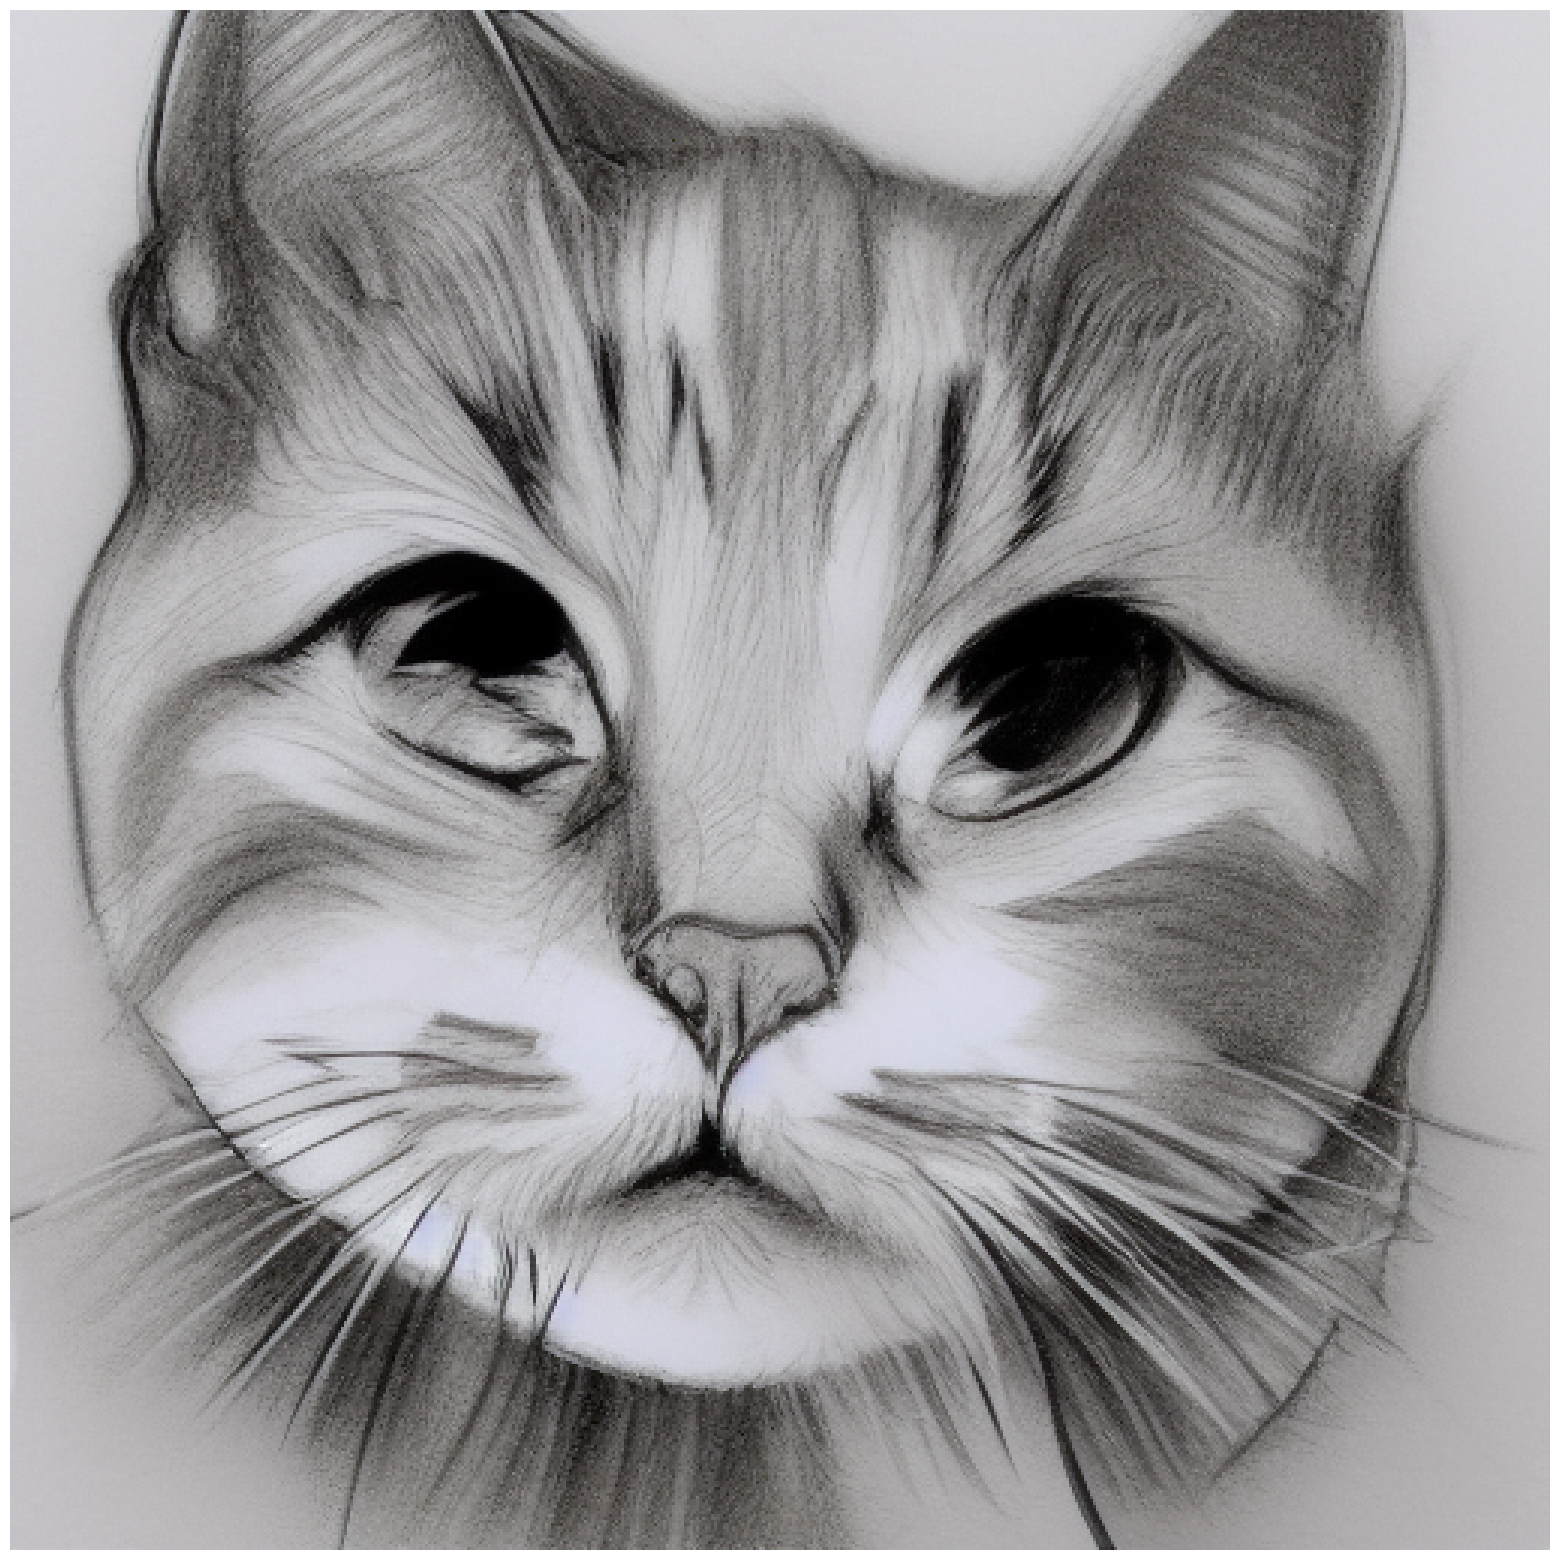

In [15]:
# https://keras.io/guides/keras_cv/generate_images_with_stable_diffusion/
import keras_cv
import tensorflow as tf
import matplotlib.pyplot as plt
    
stable_diffusion_model = keras_cv.models.StableDiffusion(img_width=512, img_height=512, jit_compile=True)

# get a random word from the filtered words list every time the code is run
import random
random_word = random.choice(filtered_words_list)

images = stable_diffusion_model.text_to_image(
    prompt= "Pretty " + random_word + synonym_word + " sketch",
    batch_size=1,  # How many images to generate at once
    num_steps=10,  # Number of iterations (controls image quality)
    seed=123,  # Set this to always get the same image from the same prompt
)


def plot_images(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")


print(plot_images(images))